In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import CIFAR10
import numpy as np
import scipy.stats as stats
import math
import random

SEED = 0
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

full_dataset = CIFAR10(root='./data/', train=True, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/


In [20]:
np.random.seed(SEED)

full = np.arange(0, len(full_dataset), 1, dtype=int)
eval = np.random.choice(full, 0, replace=False)
train = list(set(full) - set(eval))

In [21]:
eval_dataset = torch.utils.data.Subset(full_dataset, eval)
train_dataset = torch.utils.data.Subset(full_dataset, train)

In [22]:
total = len(train) 

#### Change these numbers ####

num_clients = 10
num_classes = 10
ex_per_class = total / num_classes
ALPHA = 0.1

alpha = np.repeat(ALPHA, num_classes)

rv = stats.dirichlet.rvs(alpha, size=num_clients, random_state=SEED) 
rv = rv / rv.sum(axis=0)

split_total = []
for r in rv:
  split = [round(p*(ex_per_class)) for p in r]
  split_total.append(split)
split_total = np.array(split_total)

print("Number of examples per user", split_total.sum(axis=0))

Number of examples per user [5001 5000 4999 4998 5001 4999 5000 5000 5000 5000]


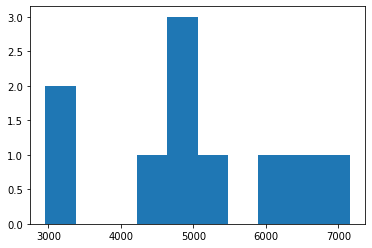

In [23]:
import matplotlib.pyplot as plt

plt.hist(split_total.sum(axis=1))
plt.show()

In [24]:
sorted_train = sorted(train_dataset, key=lambda x: x[1])
cs_split = np.cumsum(split_total, axis=0)
labels = [i for _, i in sorted_train]
label_idx = [labels.index(i) for i in range(10)]

In [25]:
split_dataset = []

for row, (split, cumsum) in enumerate(zip(split_total, cs_split)):
  user = []
  for col, (num, cs) in enumerate(zip(split, cumsum)):
    if num == 0: continue
    start = label_idx[col] + cs - num
    end = label_idx[col] + cs
    while end < len(labels) and labels[end] != col:
      end -= 1
    user.extend(range(start, end))
  split_dataset.append(user)

In [26]:
from itertools import chain
rem = list(set(range(len(train_dataset))) - set(chain.from_iterable(split_dataset)))

In [27]:
for i, u in enumerate(split_dataset):
  while len(rem) != 0 and len(u) < (total // num_clients):
    split_dataset[i] += [rem.pop()]

In [28]:
train_dataset = [[sorted_train[i] for i in u] for u in split_dataset]

In [29]:
train_data = [list(zip(*one_user_data)) for one_user_data in train_dataset]

In [12]:
eval_data = list(zip(*eval_dataset))

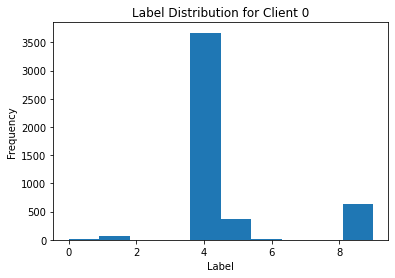

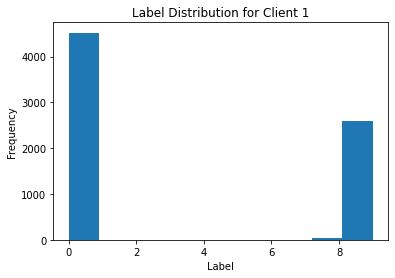

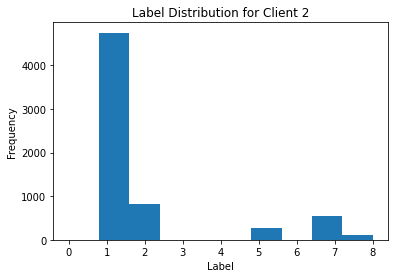

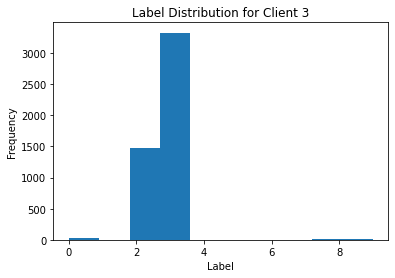

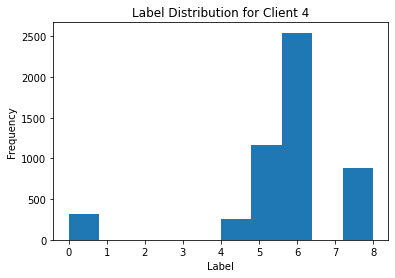

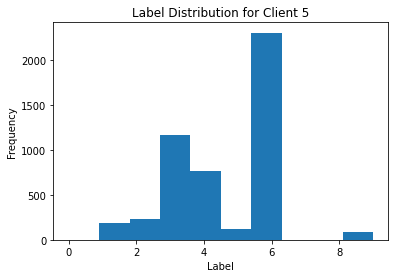

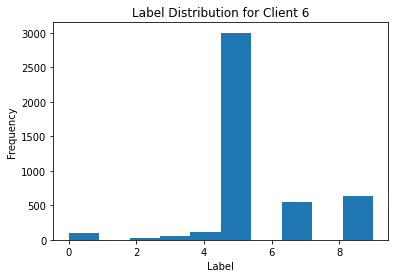

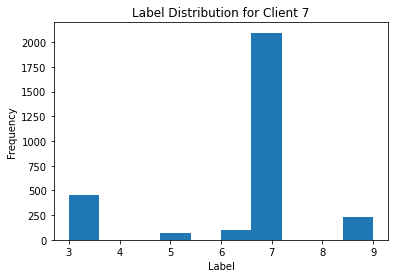

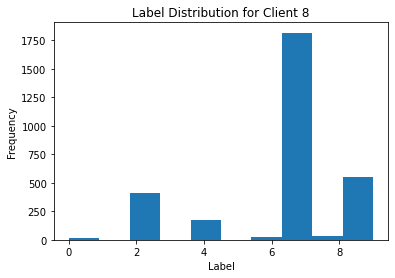

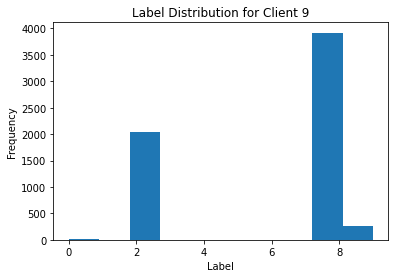

In [30]:
for i in range(num_clients):
  plt.hist([x[1] for x in train_dataset[i]])
  plt.xlabel("Label")
  plt.ylabel("Frequency")
  plt.title(f"Label Distribution for Client {i}")
  plt.show()

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
torch.save(train_data, f"/content/gdrive/My Drive/data/cifar10/cifar_{num_clients}users_alpha{ALPHA}_seed{SEED}_train.pt")

In [15]:
torch.save(eval_data, f"/content/gdrive/My Drive/data/cifar10/cifar_{num_clients}users_alpha{ALPHA}_seed{SEED}_eval.pt")

In [ ]:
load_train = torch.load("/content/gdrive/My Drive/data/cifar10/train_0.1_seed_0.pt")